In [1]:
## Importing all the necessary libraries

In [2]:
##pip install pandas

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
##!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py

In [5]:
##pip install transformers

In [6]:
##pip install ml-helper

In [7]:
##pip install tensorflow

In [8]:
# pip install nltk

In [9]:
# pip install tf-keras

In [51]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
import pydot as pyd

## Loading the train, validation and test datasets

In [13]:
import pandas as pd

In [14]:
train = pd.read_csv("train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

## Combining the train, validation and test datasets into a single dataframe

In [15]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,7353,i am sure feeling nervous about potential air ...,fear
1,13523,i feel helpless lost upset and worst of all,sadness
2,4080,i will cry in front of my children and feel ov...,surprise
3,15118,i don t recommend carrying around handfuls of ...,joy
4,5337,i may rant but i don t feel burdened in the le...,sadness


In [16]:
df.drop('index',axis=1,inplace=True)

In [17]:
df.shape

(2000, 2)

## Text Preprocessing

In [18]:
def preprocess_data(df,col):
    df[col] = df[col].apply(func=clean_html)
    df[col] = df[col].apply(func=remove_digits)
    df[col] = df[col].apply(func=remove_)
    df[col] = df[col].apply(func=removeStopWords)
    df[col] = df[col].apply(func=remove_links)
    df[col] = df[col].apply(func=remove_special_characters)
    df[col] = df[col].apply(func=non_ascii)
    df[col] = df[col].apply(func=email_address)
    df[col] = df[col].apply(func=punct)
    df[col] = df[col].apply(func=lower)
    return df

In [19]:
preprocessed_df = preprocess_data(df,'Input')
preprocessed_df.head()

,Input,Sentiment
0,sure feeling nervous potential air raids luftw...,fear
1,feel helpless lost upset worst,sadness
2,cry front children feel overwhelmed without mo...,surprise
3,recommend carrying around handfuls gold jewelr...,joy
4,may rant feel burdened least bit,sadness


In [20]:
preprocessed_df['num_words'] = preprocessed_df.Input.apply(len)

In [21]:
preprocessed_df.head()

,Input,Sentiment,num_words
0,sure feeling nervous potential air raids luftw...,fear,50
1,feel helpless lost upset worst,sadness,30
2,cry front children feel overwhelmed without mo...,surprise,57
3,recommend carrying around handfuls gold jewelr...,joy,134
4,may rant feel burdened least bit,sadness,32


In [22]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

## Train-Test Split

In [23]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.Sentiment)

## Loading the Tokenizer class and pretrained BERT model

In [24]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

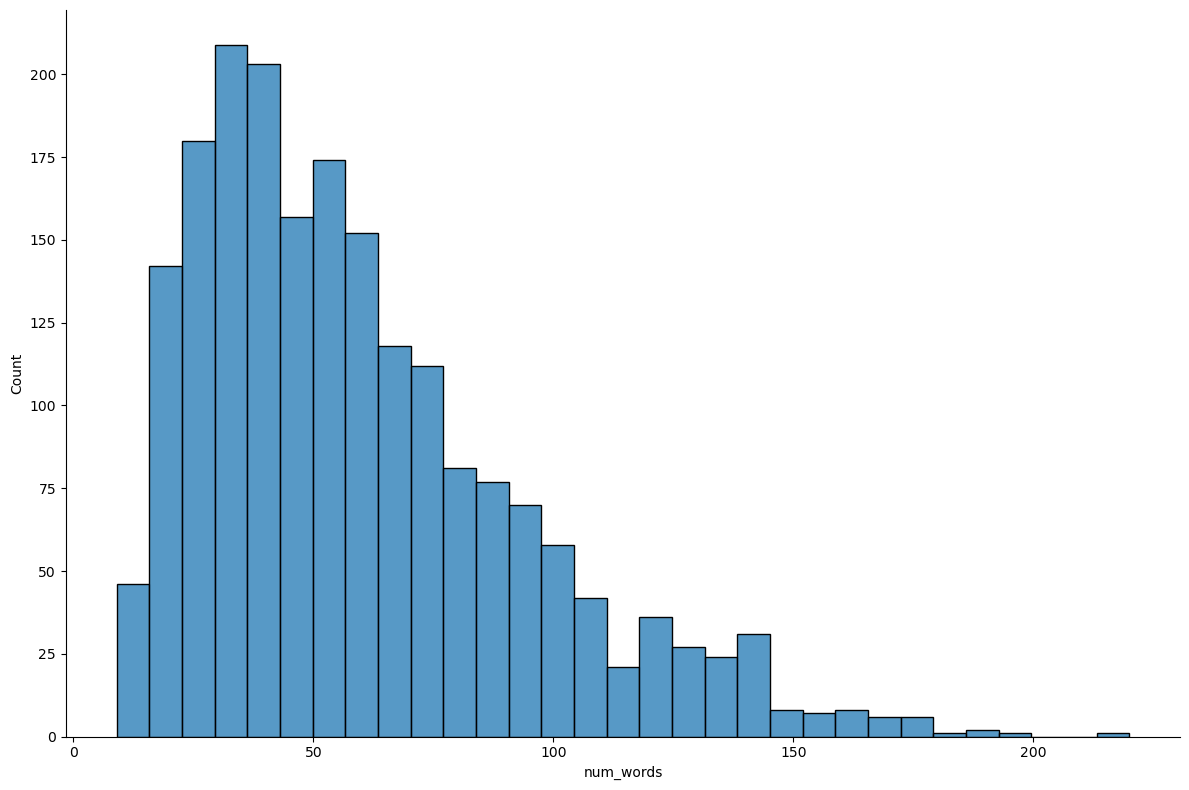

In [25]:
sns.displot(preprocessed_df.num_words,height=8,aspect=1.5)

In [26]:
max_len = 40

## Text Tokenization

In [27]:
X_train = tokenizer(text=train_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Defining the model architecture

In [28]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

In [29]:
# Use the pooled_output of the BERT model as the model's output
# pooled_output = bert_model(input_ids_arr, attention_mask=attention_mask_arr)[1]  # Index 1 is the pooled_output
# model = Model(inputs=[input_ids_str, attention_mask_str], outputs=pooled_output)

In [30]:
# input_ids_tensor = Input(shape=(max_len,), name='input_ids', dtype=tf.int32)
# attention_mask_tensor = Input(shape=(max_len,), name='attention_mask', dtype=tf.int32)

# Use the input layers with the BERT model
# outputs = bert_model(input_ids_arr, attention_mask=attention_mask_arr)[0]
# output = GlobalMaxPool1D()(embeddings)
# output = Dense(units=128,activation='relu')(output)
# output = Dropout(0.1)(output)
# output = Dense(units=64,activation='relu')(output)
# output = Dense(units=32,activation='relu')(output)
# y = Dense(units=6,activation='softmax')(output)
# # Define your model
# model = Model(inputs=[input_ids, attention_mask], outputs=y)

In [31]:
# result = tf.reduce_sum(y, axis=1)

In [32]:
# output_data_float32

In [33]:
# input_ids = Input(shape=(X_train['input_ids'].shape[1],), dtype=tf.int32)
# attention_mask = Input(shape=(X_train['attention_mask'].shape[1],), dtype=tf.int32)

In [34]:
# output = Dense(units=32, activation='relu')(output)
# y = Dense(units=6, activation='softmax')(output)

In [35]:
embeddings = bert_model(X_train['input_ids'], attention_mask=X_train['attention_mask'])[0]
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=6,activation='softmax')(output)
outputs_placeholder = tf.keras.layers.Input(shape=(6,), dtype=tf.float32)
output_assign = tf.keras.layers.Lambda(lambda x: outputs_placeholder)(y)
model = Model(inputs=[input_ids,attention_mask],outputs=output_assign)
model.layers[2].trainable = True

## Compiling the model

In [76]:
model.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=5e-5, epsilon=1e-8, decay=0.01, clipnorm=1.0),
    metrics=[CategoricalAccuracy(name='balanced_accuracy')]
)

## Encoding the emotion labels

In [77]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)

In [78]:
train_data.head()

,Input,Sentiment,num_words,Label
197,feel curious excited impatient,surprise,30,5
1818,feel particularly uncomfortable much driver lo...,fear,74,1
917,awful year racing feeling exhausted time,sadness,40,4
1933,feel insulted victim triangle,anger,29,0
960,ove even feeling discouraged,sadness,28,4


In [79]:
test_data.head()

,Input,Sentiment,num_words,Label
1615,feel guilt caring im,love,20,3
1171,eft feeling pretty chuffed finds,joy,32,2
632,feeling lied abused lenders,sadness,27,4
481,feel repressed one,sadness,18,4
1210,feel burdened subjects taking,sadness,29,4


## Generating the model summary and plot

In [80]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [81]:
pip install pydot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [82]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Training and fine-tuning the pretrained BERT model 

In [72]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming X_train['input_ids'] and X_train['attention_mask'] are lists of sequences
max_seq_length = 40  # Set the maximum sequence length

X_train_padded = pad_sequences(X_train['input_ids'], maxlen=max_seq_length, padding='post')
X_test_padded = pad_sequences(X_test['input_ids'], maxlen=max_seq_length, padding='post')

# Make sure to do the same for X_train['attention_mask'] if needed

In [74]:
input_ids = Input(shape=(max_seq_length,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(max_seq_length,), dtype='int32', name='attention_mask')

# Modify your model to use the new input layers
model = Model(inputs=[input_ids, attention_mask], outputs=output_assign)

In [85]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense
from tensorflow.keras.models import Model

# Define input layers
input_ids = Input(shape=(40,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(40,), dtype='int32', name='attention_mask')

# Example: Add an embedding layer
embedding_layer = Embedding(input_dim=6, output_dim=150)(input_ids)

# Example: Flatten or process the embedding layer
flattened = Flatten()(embedding_layer)

# Example: Add more layers as needed
dense_layer = Dense(128, activation='relu')(flattened)
output_layer = Dense(6, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 150)   │        900 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6000)      │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    768,128 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 6)         │        774 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769,802 (2.94 MB)

 Trainable params: 769,802 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=10,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

Epoch 1/10


ValueError: Input 0 of layer "functional_5" is incompatible with the layer: expected shape=(None, 40), found shape=(None, 36)

## Analyzing model performance

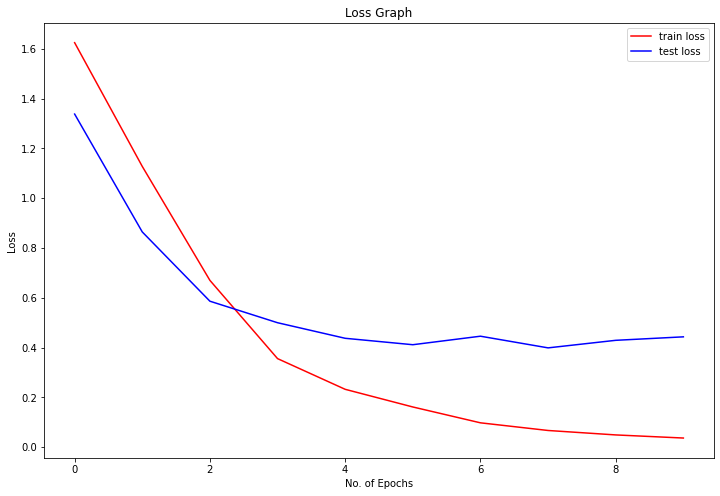

In [281]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

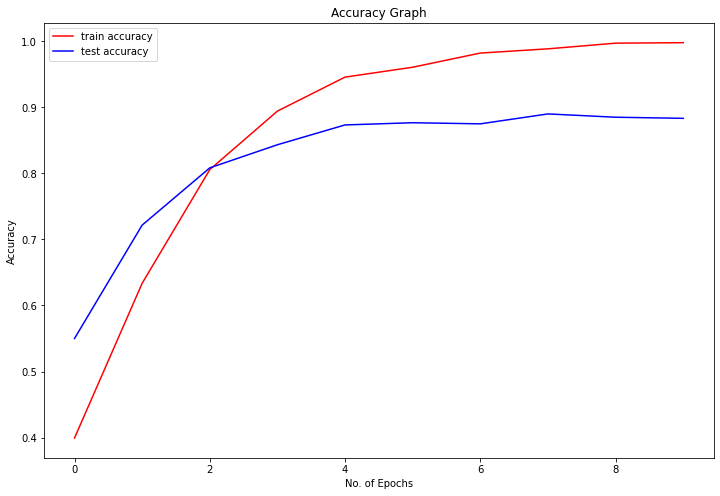

In [282]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [284]:
model.save("emotion_detector.h5")

## Evaluating the model on the test dataset

In [285]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

19/19 [==============================] - 5s 91ms/step - loss: 1.1729 - balanced_accuracy: 0.8833
Test Categorical Cross-Entropy Loss: 1.1729487180709839
Test Categorical Accuracy: 0.8833333253860474


In [286]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        77
           1       0.82      0.85      0.83        68
           2       0.93      0.89      0.91       209
           3       0.69      0.81      0.75        54
           4       0.92      0.92      0.92       173
           5       0.88      0.74      0.80        19

    accuracy                           0.88       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.89      0.88      0.88       600



The result is quite promising as we've obtained an excellent f1-score of almost 80% for all the 6 emotion classes.